## Contents

* amortized variational inference (VAEs)
* improving amortized variational inference using KL annleaing
* improving amortized variational inference using constraint optimization
* avoiding latent space distribution matching using GANs

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np

# Plotting library.
from matplotlib import pyplot as plt
import seaborn as sns

# Tensorflow probability utilities
import tensorflow_probability as tfp

tfd = tfp.distributions

import warnings


In [0]:
sns.set(rc={"lines.linewidth": 2.8}, font_scale=2)
sns.set_style("whitegrid")

In [0]:
# Don't forget to select GPU runtime environment in Runtime -> Change runtime type
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
def gallery(array, ncols=10, rescale=False):
    """Data visualization code."""
    if rescale:
      array = (array + 1.) / 2
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

In [0]:
def show_digits(axis, digits, title=''):
  axis.axis('off')
  ncols = int(np.sqrt(digits.shape[0]))
  axis.imshow(gallery(digits, ncols=ncols).squeeze(axis=2), 
                 cmap='gray')
  axis.set_title(title, fontsize=15)

In [0]:
def show_latent_interpolations(generator, prior, session):
  a = np.linspace(0.0, 1.0, BATCH_SIZE)
  a = np.expand_dims(a, axis=1)

  first_latents = prior.sample()[0]
  second_latents = prior.sample()[0]

  # To ensure that the interpolation is still likely under the Gaussian prior,
  # we use Gaussian interpolation - rather than linear interpolation.
  interpolations =  np.sqrt(a) * first_latents + np.sqrt(1 - a) * second_latents

  ncols = int(np.sqrt(BATCH_SIZE))
  samples_from_interpolations = generator(interpolations)
  samples_from_interpolations_np = sess.run(samples_from_interpolations)
  plt.gray()
  axis = plt.gca()
  show_digits(
     axis, samples_from_interpolations_np, title='Latent space interpolations')

In [0]:
BATCH_SIZE = 64
NUM_LATENTS = 10
TRAINING_STEPS = 10000
NUM_SVI_UPDATES = 100

In [0]:
DECODER_VARIABLE_SCOPE = "decoder"

In [0]:
tf.reset_default_graph()

## Get the Data

We will use the MNIST dataset. Luckly, TensorFlow comes with a simple way to load it. 

In [0]:
warnings.filterwarnings('ignore')
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
print(mnist.train.images.shape)
print(type(mnist.train.images))

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
(55000, 784)
<class 'numpy.ndarray'>


In [0]:
print(mnist.train.images.shape)
print(type(mnist.train.images))

(55000, 784)
<class 'numpy.ndarray'>


### Transform the Data from Numpy Arrays to in Graph Tensors.

This allows us to use TensorFlow datasets, which ensure that a new batch from the data is being fed at each session.run. This means that we do not need to use feed_dicts to feed data to each session.

In [0]:
def make_tf_data_batch(np_data, shuffle=True):  
  # Reshape the data to image size.
  images = np_data.reshape((-1, 28, 28, 1))
  
  # Create the TF dataset.   
  dataset = tf.data.Dataset.from_tensor_slices(images)
  
  # Shuffle and repeat the dataset for training.
  # This is required because we want to do multiple passes through the entire
  # dataset when training.
  if shuffle:
    dataset = dataset.shuffle(100000).repeat()
    
  # Batch the data and return the data batch.
  batch_data = dataset.batch(BATCH_SIZE)
  one_shot_iterator = tf.compat.v1.data.make_one_shot_iterator(batch_data)
  data_batch = one_shot_iterator.get_next()
 
  return data_batch

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
print(real_data.shape)

(?, 28, 28, 1)


# Amortized variational inference (VAEs)


Instead of learning one set of posterior variables per data point, we can use function approximation to learn the distributional variables. Specifically, the posterior parameters for $x_i$ will be the output of a *learned* function $f_\theta(x_i)$, where $\theta$ are parameters shared across all data points. Can you think of why this is useful?


<h2 align="center"></h2> <img src="http://elarosca.net/vae.png?format=100w" width=500 >


Objective - maximize: 
\begin{equation}
 \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x) \log p_\theta(x|z)}  - \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z))
\end{equation}

For more information, see: 
  * https://arxiv.org/abs/1312.6114

In [0]:
def standard_decoder(z):
  with tf.variable_scope(DECODER_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    h = tf.layers.dense(z, 7 * 7 * 64, activation=tf.nn.relu)
    h = tf.reshape(h, shape=[BATCH_SIZE, 7, 7, 64])
    h = tf.layers.Conv2DTranspose(
          filters=32,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2DTranspose(
          filters=1,
          kernel_size=5,
          strides=2,
          activation=None,  # Do not activate the last layer.
          padding='same')(h)
    return tf.distributions.Bernoulli(h)

In [0]:
def big_decoder(z):
  with tf.variable_scope(DECODER_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    h = tf.layers.dense(z, 4000, activation=tf.nn.relu)
    h = tf.layers.dense(z, 4000, activation=tf.nn.relu)
    h = tf.layers.dense(z, 4000, activation=tf.nn.relu)
    h = tf.layers.dense(h, 7 * 7 * 64, activation=tf.nn.relu)
    h = tf.reshape(h, shape=[BATCH_SIZE, 7, 7, 64])
    h = tf.layers.Conv2DTranspose(
          filters=32,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2DTranspose(
          filters=32,
          kernel_size=5,
          strides=1,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2DTranspose(
          filters=32,
          kernel_size=5,
          strides=1,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2DTranspose(
          filters=1,
          kernel_size=5,
          strides=2,
          activation=None,  # Do not activate the last layer.
          padding='same')(h)
    return tf.distributions.Bernoulli(h)

In [0]:
ENCODER_VARIABLE_SCOPE = 'encoder'

In [0]:
def encoder(x):
  with tf.variable_scope(ENCODER_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    
    h = tf.layers.Conv2D(
          filters=8,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(x)
    h = tf.layers.Conv2D(
          filters=16,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2D(
          filters=32,
          kernel_size=5,
          strides=1,
          activation=tf.nn.relu,
          padding='same')(h)
    
    out_shape = 1
    for s in h.shape.as_list()[1:]:
      out_shape*= s
    
    h = tf.reshape(h, shape=[BATCH_SIZE, out_shape])
    mean = tf.layers.dense(h, NUM_LATENTS, activation=None)
    scale = tf.layers.dense(h, NUM_LATENTS, activation=None)
    return multi_normal(loc=mean, log_scale=scale)

In [0]:
def multi_normal(loc, log_scale):
  # We model the latent variables as independent
  return tfd.Independent(
      distribution=tfd.Normal(loc=loc, scale=tf.exp(log_scale)),
      reinterpreted_batch_ndims=1)

In [0]:
def make_prior():
  # Zero mean, unit variance prior.
  prior_mean = tf.zeros(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32)
  prior_log_scale = tf.zeros(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32)

  return multi_normal(prior_mean, prior_log_scale)

In [0]:
def bound_terms(data_batch, variational_posterior, decoder_fn):
  
  # !!COMPLETE>> Draw a sample from the variational posterior
  #
  # latent_sample = ??
  

  # !!COMPLETE>> Compute the logprob from the decoder model evaluated at latent_sample
  #
  # all_log_probs = ??

  
  # Since we used broadcasting, log_prob of a Bernoulli will return a log_prob for 
  # each dimension.
  all_log_probs.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

  # Reduce sum over the data dimensions
  likelihood_term = tf.reduce_sum(all_log_probs, axis=[1, 2, 3])

  # Reduce mean over the batch dimensions
  likelihood_term = tf.reduce_mean(likelihood_term)

  # !!COMPLETE>> Compute the KL divergence term
  # kl_term = ??
  
  # Reduce over the batch dimension.
  kl_term.shape.assert_is_compatible_with([BATCH_SIZE])
  kl_term = tf.reduce_mean(kl_term)
  
  return likelihood_term, kl_term

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
print(real_data.shape)

(?, 28, 28, 1)


In [0]:
prior = make_prior()

In [0]:
# Note: we no longer have to use a variable to store the data.
# We will perform one encoder update per decoder update, so it is OK for the 
# data batch to be refreshed at each run.
variational_posterior = encoder(real_data)
decoder = standard_decoder

In [0]:
# !!COMPLETE>> Compute the variational bound
# train_elbo = ??

loss =  - train_elbo

In [0]:
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

reconstructions = decoder(variational_posterior.sample()).mean()

In [0]:
# We now perform joint optimization on the encoder and decoder variables.
optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)
decoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=DECODER_VARIABLE_SCOPE)
encoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=ENCODER_VARIABLE_SCOPE)
autoencoder_vars = encoder_vars + decoder_vars
update_op = optimizer.minimize(loss, var_list=autoencoder_vars)

## Training

In [0]:
sess = tf.Session()

# Initialize all variables
# sess.run(tf.initialize_all_variables())
sess.run(tf.global_variables_initializer())

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []


for i in range(TRAINING_STEPS):
  sess.run(update_op)
  
  
  if i % 100 == 0:
    iteration_loss, iteration_likelihood, iteration_kl  = sess.run(
          [loss, likelihood_term, kl_term])
    print('Iteration {}. Loss {}. KL {}'.format(
          i, iteration_loss, iteration_kl))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)

Iteration 0. Loss 539.196533203125. KL 0.02204948477447033
Iteration 100. Loss 198.71803283691406. KL 4.2688117027282715
Iteration 200. Loss 177.23019409179688. KL 10.226387023925781
Iteration 300. Loss 132.45806884765625. KL 14.541561126708984
Iteration 400. Loss 125.61270141601562. KL 16.109647750854492
Iteration 500. Loss 116.99410247802734. KL 16.198226928710938
Iteration 600. Loss 117.24712371826172. KL 18.95182228088379
Iteration 700. Loss 134.2333984375. KL 17.74468421936035
Iteration 800. Loss 120.09989166259766. KL 17.780799865722656
Iteration 900. Loss 112.07304382324219. KL 17.73116683959961
Iteration 1000. Loss 115.76332092285156. KL 18.482267379760742
Iteration 1100. Loss 110.12649536132812. KL 17.3060302734375
Iteration 1200. Loss 112.2479476928711. KL 17.51970672607422
Iteration 1300. Loss 111.29019927978516. KL 18.701194763183594
Iteration 1400. Loss 116.5347900390625. KL 17.516788482666016
Iteration 1500. Loss 114.019287109375. KL 18.3753719329834
Iteration 1600. Loss 


### Visualize the loss in time

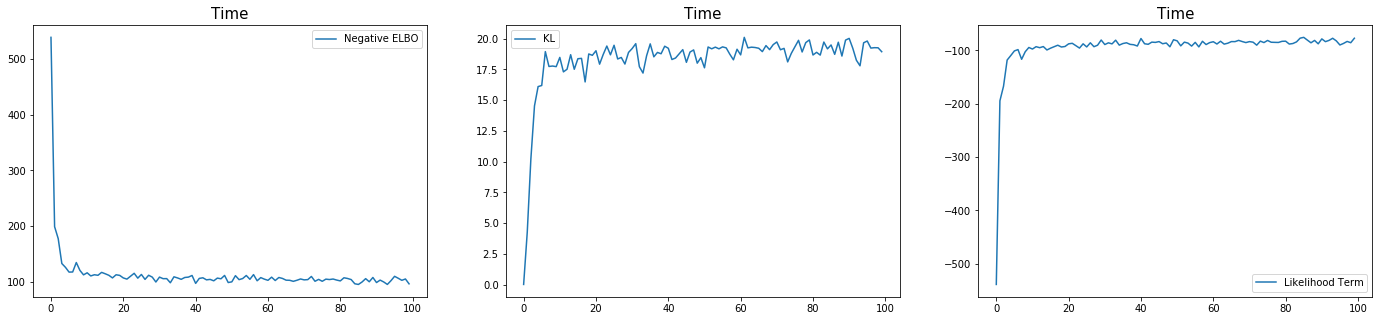

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*8,5))

axes[0].plot(losses, label='Negative ELBO')
axes[0].set_title('Time', fontsize=15)
axes[0].legend()

axes[1].plot(kls, label='KL')
axes[1].set_title('Time', fontsize=15)
axes[1].legend()

axes[2].plot(likelihood_terms, label='Likelihood Term')
axes[2].set_title('Time', fontsize=15)
axes[2].legend()

### Generate samples and latent interpolations



In [0]:
real_data_vals, final_samples_vals, data_reconstructions_vals = sess.run(
      [real_data, samples, reconstructions])

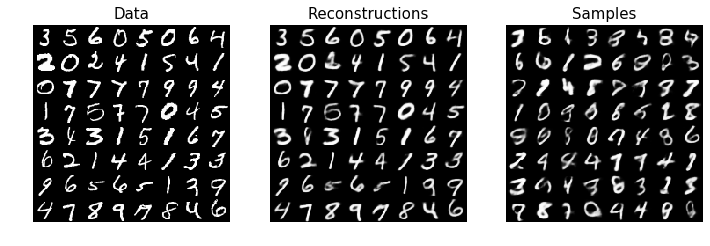

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))

show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], data_reconstructions_vals, 'Reconstructions')
show_digits(axes[2], final_samples_vals, 'Samples')

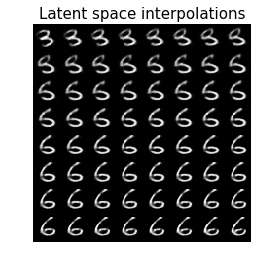

In [0]:
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Questions about amortized variational inference

* What do you observe about sample quality and reconstruction quality?
* What do you observe about the ELBO and KL term?
* Which gradient estimation method is used to compute the gradients with respect to the encoder parameters?

# KL annealing

Objective - maximize: 
\begin{equation}
 \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x) \log p_\theta(x|z)}  - \alpha \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z))
\end{equation}

Where $\alpha$ changes during training, to weigh in the KL term more.

In [0]:
tf.reset_default_graph()

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
prior = make_prior()
decoder = standard_decoder

In [0]:
kl_coefficient = tf.Variable(
    tf.zeros(shape=(1), dtype=tf.float32), 
    trainable=False,
    name='kl_coeff')

kl_step = 1.0 / TRAINING_STEPS
update_kl_coeff = tf.assign(kl_coefficient, kl_coefficient + kl_step)

In [0]:
variational_posterior = encoder(real_data)

# !!COMPLETE>> Compute the variational bound with rescaled KL coefficient
# train_elbo = ??
#


loss =  - train_elbo

In [0]:
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

reconstructions = decoder(variational_posterior.sample()).mean()

In [0]:
# We now perform joint optimization on the encoder and decoder variables.
optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)
decoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=DECODER_VARIABLE_SCOPE)
encoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=ENCODER_VARIABLE_SCOPE)
autoencoder_vars = encoder_vars + decoder_vars
variables_update_op = optimizer.minimize(loss, var_list=autoencoder_vars)

# Ensure that a variable update is followed by an update in the KL coefficient.
with tf.control_dependencies([variables_update_op]):
  update_op = tf.identity(update_kl_coeff)

## Training

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.initialize_all_variables())

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []


for i in range(TRAINING_STEPS):
  sess.run(update_op)
  
  
  if i % 100 == 0:
    iteration_loss, iteration_likelihood, iteration_kl  = sess.run(
          [loss, likelihood_term, kl_term])
    print('Iteration {}. Loss {}. KL {}'.format(
          i, iteration_loss, iteration_kl))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)

Iteration 0. Loss [539.4792]. KL 0.04104074090719223
Iteration 100. Loss [194.9967]. KL 44.48965835571289
Iteration 200. Loss [168.335]. KL 52.840965270996094
Iteration 300. Loss [131.64783]. KL 62.42009735107422
Iteration 400. Loss [117.0551]. KL 51.43534469604492
Iteration 500. Loss [100.880455]. KL 47.36773681640625
Iteration 600. Loss [98.15953]. KL 41.8781623840332
Iteration 700. Loss [97.19895]. KL 41.61931610107422
Iteration 800. Loss [89.82359]. KL 37.182716369628906
Iteration 900. Loss [91.434395]. KL 37.03062057495117
Iteration 1000. Loss [97.83667]. KL 35.20429992675781
Iteration 1100. Loss [89.1202]. KL 33.190818786621094
Iteration 1200. Loss [87.98577]. KL 33.383323669433594
Iteration 1300. Loss [88.122856]. KL 33.20022964477539
Iteration 1400. Loss [87.82192]. KL 30.42446517944336
Iteration 1500. Loss [89.218185]. KL 31.81494903564453
Iteration 1600. Loss [88.70567]. KL 31.473731994628906
Iteration 1700. Loss [89.785675]. KL 31.230899810791016
Iteration 1800. Loss [95.668

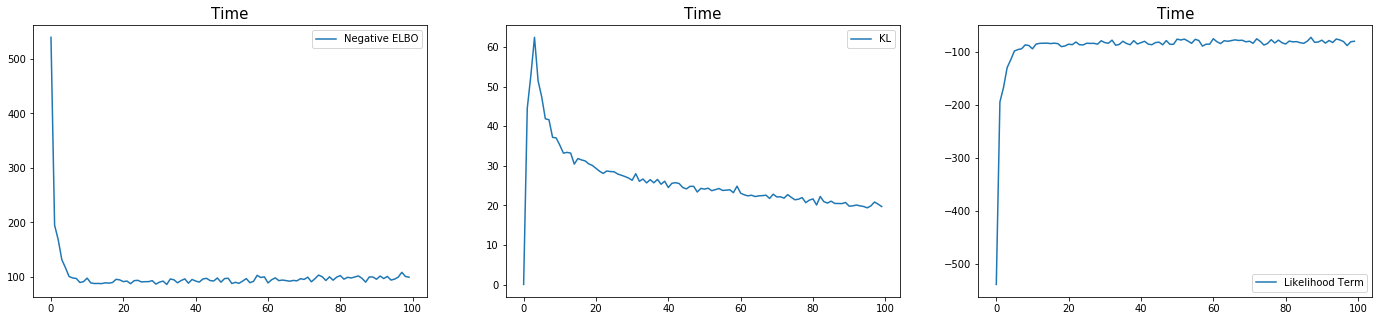

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*8,5))

axes[0].plot(losses, label='Negative ELBO')
axes[0].set_title('Time', fontsize=15)
axes[0].legend()

axes[1].plot(kls, label='KL')
axes[1].set_title('Time', fontsize=15)
axes[1].legend()

axes[2].plot(likelihood_terms, label='Likelihood Term')
axes[2].set_title('Time', fontsize=15)
axes[2].legend()

In [0]:
real_data_vals, final_samples_vals, data_reconstructions_vals = sess.run(
      [real_data, samples, reconstructions])

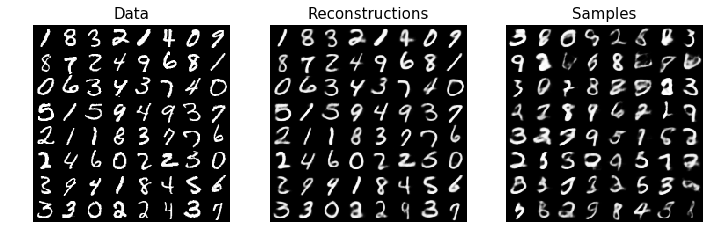

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], data_reconstructions_vals, 'Reconstructions')
show_digits(axes[2], final_samples_vals, 'Samples')

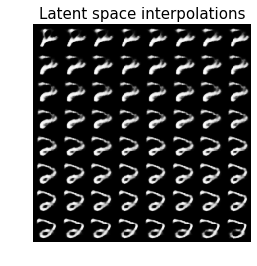

In [0]:
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Questions about KL annealing

* What do you observe about the KL behaviour throughout training as opposed to amortized variational inference without any KL annealing? 

# Constrained optimization

Instead of using KL annealing, constrained optimization can be used to automatically tuned the relative weight of the likelihood and kl terms. This removes the need to manually create an optimization schedule, which can be problem specific.

The objective now becomes:

\begin{equation}
  \text{minimize } \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z)) \text{ such that }  \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x) \log p_\theta(x|z)} > \alpha 
\end{equation}

This can be solved using the use of Lagrange multipliers. The objective becomes:

\begin{equation}
  \text{minimize }  \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z)) + \lambda  (\mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z)))
\end{equation}


The difference compared to the KL annealing is that:

   * $\lambda$ is a learned parameter - it will be learned using stochastic gradient descent, like the network parameters.  The difference is that the lagrangian has to solve a maximization problem. You can see this intuitively: the graadient with respect to $\lambda$ in the objective above is $\mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z))$. If $ \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z))> 0$, the constraint is not being satisfied, so the value of the lagrangian needs to increase. This will be done by doing gradient ascent, instead of gradient descent. Note that for $\lambda$ to be a valid lagranian in a minimization problem, it has to be positive.
   * The practicioner has to specify the hyperparameter $\alpha$, which determines the reoncstruction quality of the model.
   * the coefficient is in front of the likelihood term, not the KL term. This is mainly for convenience, as it is easier to specify the hyperparameter $\alpha$ for the likelihood (reconstruction loss).


For more assumptions made by this method, see the Karush–Kuhn–Tucker conditions.

For more information, see: 
  * http://bayesiandeeplearning.org/2018/papers/33.pdf


In [0]:
tf.reset_default_graph()

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
prior = make_prior()
decoder = standard_decoder

In [0]:
# Unlike in the KL annealing case, we learn the coefficient.
# We initialize the lagrangian such that after the softplus the coefficient is 
# approximately 1.
lagrangian_var = tf.Variable(
    0.55 * tf.ones(shape=(1), dtype=tf.float32), 
    trainable=True,
    name='lagrangian')

# Ensure that the lagrangian is positive and has stable dynamics.
lagrangian = tf.nn.softplus(lagrangian_var)

In [0]:
# How good do we want the reconstruction loss to be?
# We can look at previous runs to get an idea what a reasonable value would be.
reconstruction_target = - 90

In [0]:
variational_posterior = encoder(real_data)
likelihood_term, kl_term = bound_terms(
    real_data, variational_posterior, decoder)

# Note: now the elbo is a different quanitity to what we optimize.
# !!COMPLETE>> Implement the variational bound
# train_elbo = ??


# !!COMPLETE>> Implement the lagrangian loss function that is optimised.
# loss =  ??
#


In [0]:
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

reconstructions = decoder(variational_posterior.sample()).mean()

In [0]:
tf.trainable_variables()

[<tf.Variable 'lagrangian:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d/kernel:0' shape=(5, 5, 1, 8) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d/bias:0' shape=(8,) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_1/kernel:0' shape=(5, 5, 8, 16) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_1/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_2/kernel:0' shape=(5, 5, 16, 32) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_2/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'encoder/dense/kernel:0' shape=(1568, 10) dtype=float32_ref>,
 <tf.Variable 'encoder/dense/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'encoder/dense_1/kernel:0' shape=(1568, 10) dtype=float32_ref>,
 <tf.Variable 'encoder/dense_1/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'decoder/dense/kernel:0' shape=(10, 3136) dtype=float32_ref>,
 <tf.Variable 'decoder/dense/bias:0' shape=(3136,) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose/ke

In [0]:
lagrangian_optimizer = tf.train.GradientDescentOptimizer(0.001)

# We now perform joint optimization on the encoder and decoder variables.
optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)
decoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=DECODER_VARIABLE_SCOPE)
encoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=ENCODER_VARIABLE_SCOPE)
autoencoder_vars = encoder_vars + decoder_vars
autoencoder_variables_update_op = optimizer.minimize(
      loss, var_list=autoencoder_vars)

# Ensure that a variable update is followed by an update to the Lagrangian.
with tf.control_dependencies([autoencoder_variables_update_op]):
  # Ensure that the lagrangian solves a maximization problem instead of a
  # minimization problem by changing the sign of the loss function.
  update_op = lagrangian_optimizer.minimize(- loss, var_list=[lagrangian_var])

## Training

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.initialize_all_variables())

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []
lagrangian_values = []

for i in range(TRAINING_STEPS):
  sess.run(update_op)
  
  
  if i % 100 == 0:
    iteration_loss, iteration_likelihood, iteration_kl, lag_val  = sess.run(
          [loss, likelihood_term, kl_term, lagrangian])
    print('Iteration {}. Loss {}. KL {}. Lagrangian {}'.format(
          i, iteration_loss, iteration_kl, lag_val))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)
    lagrangian_values.append(lag_val)

Iteration 0. Loss [537.7765]. KL 0.0048736026510596275. Lagrangian [1.1971195]
Iteration 100. Loss [1897.5077]. KL 26.191951751708984. Lagrangian [18.056318]
Iteration 200. Loss [1980.6298]. KL 41.9063720703125. Lagrangian [27.26814]
Iteration 300. Loss [1119.1221]. KL 52.965667724609375. Lagrangian [31.972078]
Iteration 400. Loss [581.9747]. KL 59.35569763183594. Lagrangian [34.11227]
Iteration 500. Loss [362.915]. KL 54.883079528808594. Lagrangian [35.39999]
Iteration 600. Loss [317.58914]. KL 50.1129150390625. Lagrangian [36.20063]
Iteration 700. Loss [402.21625]. KL 52.07322692871094. Lagrangian [36.832962]
Iteration 800. Loss [44.509346]. KL 52.564788818359375. Lagrangian [37.237885]
Iteration 900. Loss [145.89885]. KL 50.428306579589844. Lagrangian [37.375645]
Iteration 1000. Loss [252.88945]. KL 48.64805603027344. Lagrangian [37.489204]
Iteration 1100. Loss [86.101105]. KL 49.36549377441406. Lagrangian [37.484894]
Iteration 1200. Loss [-187.32822]. KL 48.465309143066406. Lagrang

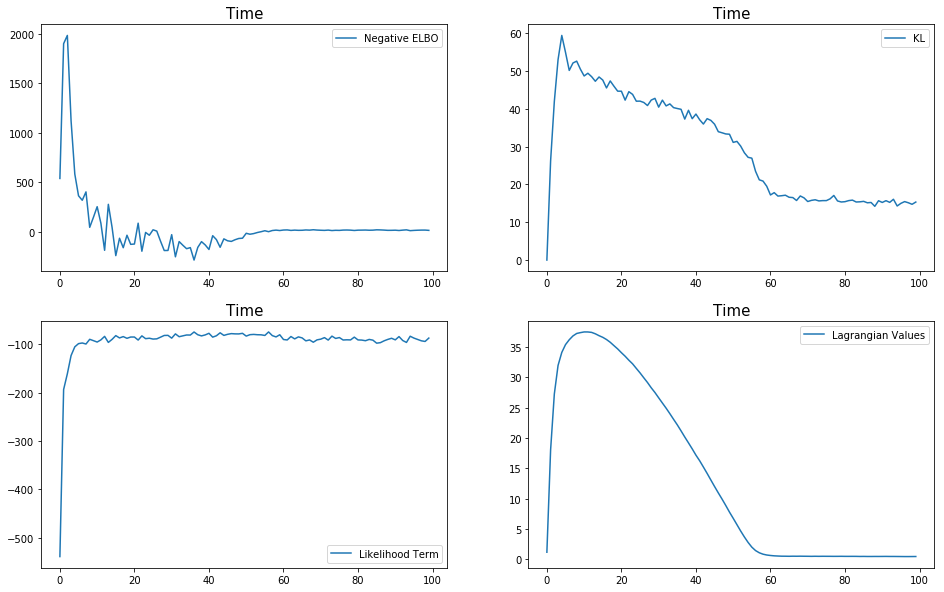

In [0]:
fig, axes = plt.subplots(2, 2, figsize=(2*8, 2* 5))

axes[0, 0].plot(losses, label='Negative ELBO')
axes[0, 0].set_title('Time', fontsize=15)
axes[0, 0].legend()

axes[0, 1].plot(kls, label='KL')
axes[0, 1].set_title('Time', fontsize=15)
axes[0, 1].legend()

axes[1, 0].plot(likelihood_terms, label='Likelihood Term')
axes[1, 0].set_title('Time', fontsize=15)
axes[1, 0].legend()

axes[1, 1].plot(lagrangian_values, label='Lagrangian Values')
axes[1, 1].set_title('Time', fontsize=15)
axes[1, 1].legend()

### Generate samples and latent interpolations

In [0]:
real_data_vals, final_samples_vals, data_reconstructions_vals = sess.run(
      [real_data, samples, reconstructions])

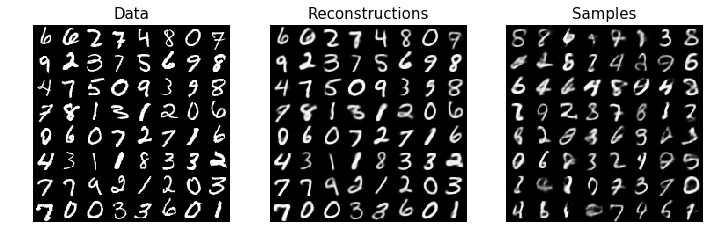

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], data_reconstructions_vals, 'Reconstructions')
show_digits(axes[2], final_samples_vals, 'Samples')

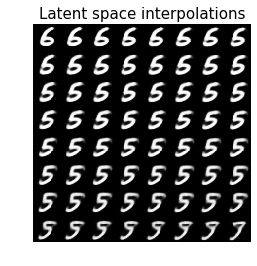

In [0]:
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Discussion about constrained optimization

* What do you observe about the behaviour of the likelihood and KL term throughout training? How is it different than in Amortized Variational inference with and without KL annealing?
* What do you notice about the behaviour of the lagrangian during training?
* How would you choose the hyperparameters of the constrained optimization problem?